In [1]:
import torch
import torchvision
from torchvision import datasets, transforms
from torch.autograd import Variable
import numpy
import matplotlib.pyplot as plt

In [2]:
train_data = torchvision.datasets.MNIST(
    root = './data/MINIST',  #数据集的位置
    train = True,       #如果为True则为训练集，如果为False则为测试集
    transform = torchvision.transforms.ToTensor(),   #将图片转化成取值[0,1]的Tensor用于网络处理
    download=True                         #先下载数据集
)

In [2]:
train_data = torchvision.datasets.MNIST(
    root = './data/MINIST',  #数据集的位置
    train = True,       #如果为True则为训练集，如果为False则为测试集
    transform = torchvision.transforms.ToTensor()   #将图片转化成取值[0,1]的Tensor用于网络处理
)
test_data = torchvision.datasets.MNIST(
    root = './data/MINIST',  #数据集的位置
    train = False,       #如果为True则为训练集，如果为False则为测试集
    transform = torchvision.transforms.ToTensor()   #将图片转化成取值[0,1]的Tensor用于网络处理
)

In [3]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data/MINIST
    Split: Train
    StandardTransform
Transform: ToTensor()

In [5]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: ./MINIST
    Split: Test
    StandardTransform
Transform: ToTensor()

In [6]:
#使用原始数据的均值(Mean)和标准差(Standard Deviation)来进行数据的标准化,
#在经过标准化变换之后,数据全部符合均值为 0、标准差为 1 的标准正态分布
#这里假设均值为0.5,标准差为0.5,都为3个通道
transform=transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize(mean=[0.5,0.5,0.5],
                                                   std=[0.5,0.5,0.5])])

In [7]:
transform

Compose(
    ToTensor()
    Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
)

In [8]:
data_loader_train=torch.utils.data.DataLoader(train_data,
                                             batch_size=64,
                                              shuffle = True)
data_loader_test=torch.utils.data.DataLoader(test_data,
                                             batch_size=64,
                                              shuffle = True)

In [9]:
#next读取iter迭代器的下一个，这里读取第一个
images, labels = next(iter(data_loader_train))
img = torchvision.utils.make_grid(images)

In [10]:
images.size()

torch.Size([64, 1, 28, 28])

In [11]:
img = img.numpy().transpose(1,2,0)

[tensor(3), tensor(6), tensor(0), tensor(5), tensor(9), tensor(1), tensor(8), tensor(5), tensor(3), tensor(7), tensor(2), tensor(5), tensor(5), tensor(0), tensor(9), tensor(4), tensor(3), tensor(9), tensor(2), tensor(0), tensor(6), tensor(8), tensor(6), tensor(6), tensor(1), tensor(6), tensor(7), tensor(9), tensor(7), tensor(9), tensor(6), tensor(4), tensor(0), tensor(7), tensor(5), tensor(1), tensor(8), tensor(7), tensor(1), tensor(9), tensor(8), tensor(6), tensor(6), tensor(5), tensor(4), tensor(6), tensor(0), tensor(1), tensor(0), tensor(4), tensor(8), tensor(6), tensor(4), tensor(0), tensor(8), tensor(7), tensor(9), tensor(1), tensor(0), tensor(7), tensor(0), tensor(8), tensor(1), tensor(8)]


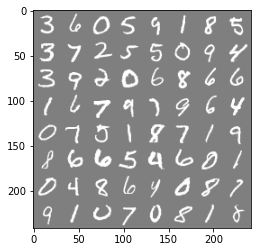

In [12]:
std = [0.5,0.5,0.5]
mean=[0.5,0.5,0.5]
img = img*std+mean
print([labels[i] for i in range(64)])
plt.imshow(img)

In [13]:
#Paddingde 的数据类型是整型,值为 0 时表示不进行边界像素的填充,如果值大于 0,则增加相应边界像素层数
#Dropout 类用于防止卷积神经网络在训练的过程中发生过拟合，模型训练的过程中,以一定的随机概率将卷积神经网络模型的部分参数归零,以减少相邻两层神经连接
class Model(torch.nn.Module):
    def __init__(self):
        super(Model,self).__init__()
        self.conv1=torch.nn.Sequential(
                torch.nn.Conv2d(1,64,kernel_size=3,stride=1,padding=1),
                torch.nn.ReLU(),
                torch.nn.Conv2d(64,128,kernel_size=3,stride=1,padding=1),
                torch.nn.MaxPool2d(stride=2,kernel_size=2))
        self.dense=torch.nn.Sequential(
                torch.nn.Linear(14*14*128,1024),
                torch.nn.ReLU(),
                torch.nn.Dropout(p=0.5),
                torch.nn.Linear(1024,10))
    def forward(self,x):
        x=self.conv1(x)
        x=x.view(-1,14*14*128)
        x=self.dense(x)
        return x
    

In [14]:
model = Model()
cost = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.00001)

In [15]:
torch.cuda.is_available()

True

In [16]:
n_epochs = 5

Use_gpu=1
if Use_gpu:
    model=model.cuda()

In [17]:
for epoch in range(n_epochs):
    
    running_loss=0.0
    running_correct=0
    
    print("Epoch{}/{}".format(epoch,n_epochs))
    print("-"*10)
    
    for data in data_loader_train:
        x,y=data
#        if Use_gpu:
        x,y=Variable(x.cuda()),Variable(y.cuda()) #gpu的运算类型
#        else:
#            x,y=Variable(x),Variable(y) #cpu的运算类型

        y_pred=model(x) #输出预测y

        _,pred=torch.max(y_pred.data,1) #限幅

        optimizer.zero_grad()
        loss=cost(y_pred,y)
        
        loss.backward()
        optimizer.step()
#        running_loss+=loss.data
#        running_correct+=torch.sum(pred==y.data)
#        print("Loss is:{:.4f},Train Accuracy is:{:.4f}%".format(running_loss/len(test_data),100*running_correct/len(train_data)))
#     testing_correct=0
#     for data in data_loader_test:
#         x_test,y_test=data
#         x_test,y_test=Variable(x_test),Variable(y_test)
#         outputs=model(x_test)
#         _,pred=torch.max(outputs.data,1)
#         testing_correct+=torch.sum(pred==y_test.data)
#     print("Loss is:{:.4f},Train Accuracy is:{:.4f}%,Test Accuracy is{:.4f}".format(running_loss/len(test_data),100*running_correct/len(train_data),100*testing_correct/len(test_data)))

Epoch0/5
----------
Epoch1/5
----------
Epoch2/5
----------
Epoch3/5
----------
Epoch4/5
----------


In [18]:
data_loader_test_with_4=torch.utils.data.DataLoader(dataset=test_data,
                                                    batch_size=4,
                                                    shuffle=True)

In [24]:
x_test,y_test=next(iter(data_loader_test_with_4))
inputs=Variable(x_test.cuda())
pred=model(inputs)
_,pred=torch.max(pred,1)
pred

tensor([7, 2, 3, 1], device='cuda:0')

predict Label is: [tensor(7, device='cuda:0'), tensor(2, device='cuda:0'), tensor(3, device='cuda:0'), tensor(1, device='cuda:0')]
Real Label is: [tensor(7), tensor(2), tensor(3), tensor(1)]


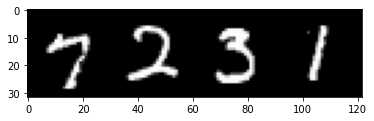

In [25]:
print("predict Label is:",[i for i in pred.data])
print("Real Label is:",[i for i in y_test])

img = torchvision.utils.make_grid(x_test)
img = img.numpy().transpose(1,2,0)

# std = [0.5,0.5,0.5]
# mean = [0.5,0.5,0.5]
# img = img*std+mean
plt.imshow(img)

In [26]:
torch.cuda.empty_cache()